Morphing of Images using pretrained network of styleGAN2 on customized dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
NETWORK = "/content/stylegan2-ada-pytorch/network-snapshot-019756.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 20

In [ ]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 30.21 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 19.2 MB/s 


# Upload Starting Image

Choose your starting image.

In [ ]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving seed20978.png to seed20978.png


Also, choose your ending image.

In [ ]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving seed20880.png to seed20880.png


# Convert Source to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=source.png --network={NETWORK}"
!{cmd}

Loading networks from "/content/stylegan2-ada-pytorch/network-snapshot-019756.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %105 : int = prim::profile_ivalue(%103)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1130: UserWarning: concrete shape for bias input is required to decompose into conv + bias (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:2233.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.86 loss 24567.53
step    2/1000: dist 0.98 loss 27640.96
step    3/1000: dist 1.04 loss 27167.15
step    4/1000: dist 1.00 loss 26253.79
step    5/10

# Convert Target to a GAN

Next, we convert the target to a GAN latent vector.  This process will also take several minutes.

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=target.png --network={NETWORK}"
!{cmd}

Loading networks from "/content/stylegan2-ada-pytorch/network-snapshot-019756.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %105 : int = prim::profile_ivalue(%103)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1130: UserWarning: concrete shape for bias input is required to decompose into conv + bias (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:2233.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.54 loss 24567.21
step    2/1000: dist 0.71 loss 27640.69
step    3/1000: dist 0.72 loss 27166.84
step    4/1000: dist 0.72 loss 26253.52
step    5/10

With the conversion complete, lets have a look at the two GANs.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt

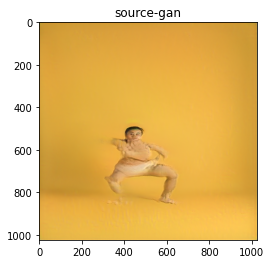

In [ ]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

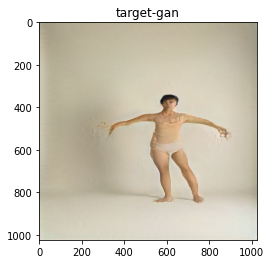

In [ ]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [ ]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.2 MB/s 


In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "/content/stylegan2-ada-pytorch/network-snapshot-019756.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1

  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
from google.colab import files
files.download("movie.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>